## Loading data

In [17]:
import pandas as pd

In [18]:
data = pd.read_csv("../data/raw_data.csv")

 ## Preprocessing the data

In [19]:
from sklearn.model_selection import train_test_split
import nltk
import string
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sayan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sayan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [20]:
stopwords = set(stopwords.words('english'))

In [21]:
# Preprocessing
lemmatizer = WordNetLemmatizer()

# Lower casing
data['text'] = data['text'].str.lower()

# Removing punctuation
data['text'] = data['text'].apply(lambda x: ''.join([char for char in x if char not in string.punctuation]))

# Tokenization
data['text'] = data['text'].apply(lambda x: x.split())

# Removing stop words
data['text'] = data['text'].apply(lambda x: [word for word in x if word not in stopwords])

# Lemmatization
data['text'] = data['text'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

# Joining the tokens
data['text'] = data['text'].apply(lambda x: ' '.join(x))

# Removing empty strings
data = data[data['text'] != '']

# Count Vectorization
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
temp = cv.fit_transform(data.text)
data = pd.concat([data, pd.DataFrame(temp.toarray())], axis=1)
data = data.drop('text', axis=1)

In [22]:
# Splitting the data
# 80% for training and 20% for testing
train_data, temp_data = train_test_split(data, test_size=0.2, random_state=42)
# Split temp set into validation and test sets
validation_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

In [23]:
# helper function for plotting the aucpr curve
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

def plot_aucpr_curve(y_true, y_probs, model_name):

    # Calculate precision-recall curve
    precision, recall, _ = precision_recall_curve(y_true, y_probs)

    # Calculate AUC-PR
    aucpr = auc(recall, precision)

    # Plot the AUC-PR curve
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='darkorange', lw=2, label=f'{model_name} (AUC-PR = {aucpr:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower right')
    plt.show()


## Attaching mlflow to the current file

In [24]:
import mlflow
from mlflow.models import infer_signature
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")

In [25]:
X_train, y_train = train_data.drop('spam', axis=1), train_data.spam

In [26]:
X_validation, y_validation = validation_data.drop('spam', axis=1), validation_data.spam

In [27]:
X_test, y_test = test_data.drop('spam', axis=1), test_data.spam

## SVC Model

In [34]:
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error

In [35]:
with mlflow.start_run() as run:
    model = SVC()
    model.fit(X_train, y_train)
    y_predict = model.predict(X_validation)
    signature = infer_signature(X_validation, y_validation)
    mlflow.log_metrics({"mse": mean_squared_error(y_validation, y_predict)})
    mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path="sklearn-model",
        signature=signature,
        registered_model_name="SVC Model",
    )

C:\Users\sayan\anaconda3\Lib\site-packages\mlflow\types\utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
C:\Users\sayan\anaconda3\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'SVC Model'.
2024/02/20 22:30:11 INFO 

## Naive Bayes Model

In [36]:
from sklearn.naive_bayes import MultinomialNB

In [38]:
with mlflow.start_run() as run:
    model = MultinomialNB()
    model.fit(X_train, y_train)
    y_predict = model.predict(X_validation)
    signature = infer_signature(X_validation, y_validation)
    mlflow.log_metrics({"mse": mean_squared_error(y_validation, y_predict)})
    mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path="sklearn-model",
        signature=signature,
        registered_model_name="Naive Bayes Model",
    )

C:\Users\sayan\anaconda3\Lib\site-packages\mlflow\types\utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Successfully registered model 'Naive Bayes Model'.
2024/02/20 22:31:01 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Naive Bayes Model, version 1
Created version '1' 

## Random Forest Model

In [39]:
from sklearn.ensemble import RandomForestClassifier

In [40]:
with mlflow.start_run() as run:
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_validation)
    signature = infer_signature(X_validation, y_validation)
    mlflow.log_metrics({"mse": mean_squared_error(y_validation, y_predict)})
    mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path="sklearn-model",
        signature=signature,
        registered_model_name="Random Forest Model",
    )

C:\Users\sayan\anaconda3\Lib\site-packages\mlflow\types\utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Successfully registered model 'Random Forest Model'.
2024/02/20 22:31:39 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Random Forest Model, version 1
Created version 

## Loading SVC Model

In [41]:
logged_model = 'runs:/8e6dd94bba474a67a5faf6475702964f/sklearn-model'
svc = mlflow.pyfunc.load_model(logged_model)

C:\Users\sayan\anaconda3\Lib\site-packages\mlflow\models\utils.py:673: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_pf_input[name] = _enforce_mlflow_datatype(name, pf_input[name], input_type)


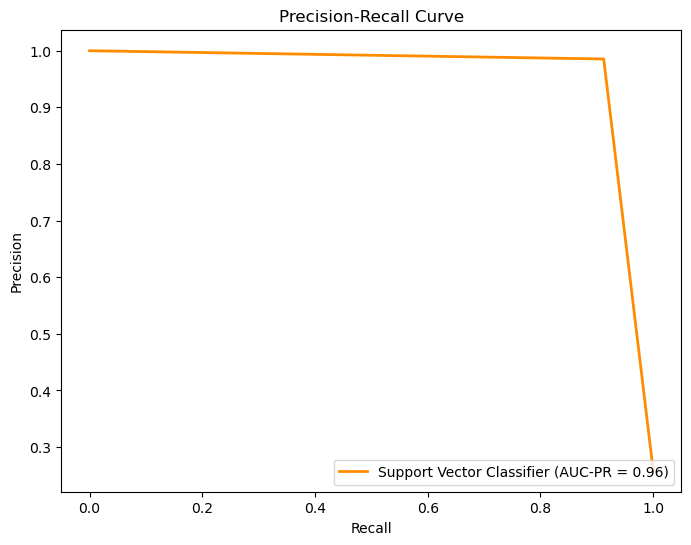

In [43]:
y_pred = svc.predict(X_test)
plot_aucpr_curve(y_test, y_pred, "Support Vector Classifier")

## Loading Naive Bayes Model

In [45]:
logged_model = 'runs:/4a5717263f0e4da3b817500bdd7bb07f/sklearn-model'
nb = mlflow.pyfunc.load_model(logged_model)

C:\Users\sayan\anaconda3\Lib\site-packages\mlflow\models\utils.py:673: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_pf_input[name] = _enforce_mlflow_datatype(name, pf_input[name], input_type)


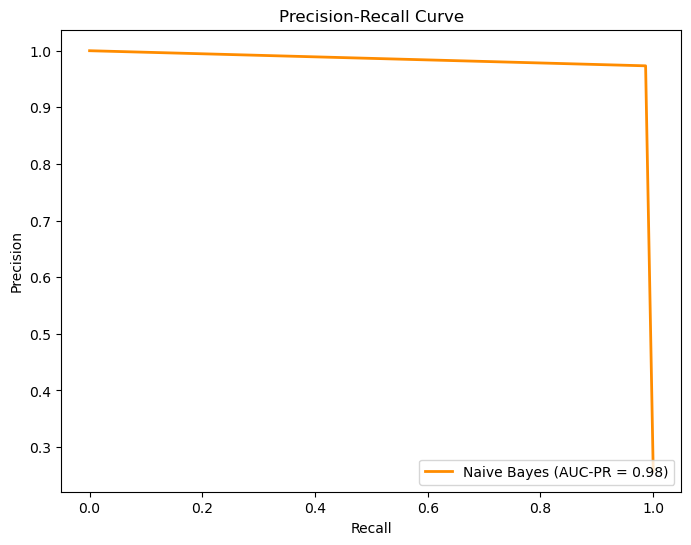

In [46]:
y_pred = nb.predict(X_test)
plot_aucpr_curve(y_test, y_pred, "Naive Bayes")

## Loading Random Forest Model

In [47]:
logged_model = 'runs:/e0e2f0e624884d9a86807f6c03a3e305/sklearn-model'
random_forest = mlflow.pyfunc.load_model(logged_model)

C:\Users\sayan\anaconda3\Lib\site-packages\mlflow\models\utils.py:673: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_pf_input[name] = _enforce_mlflow_datatype(name, pf_input[name], input_type)


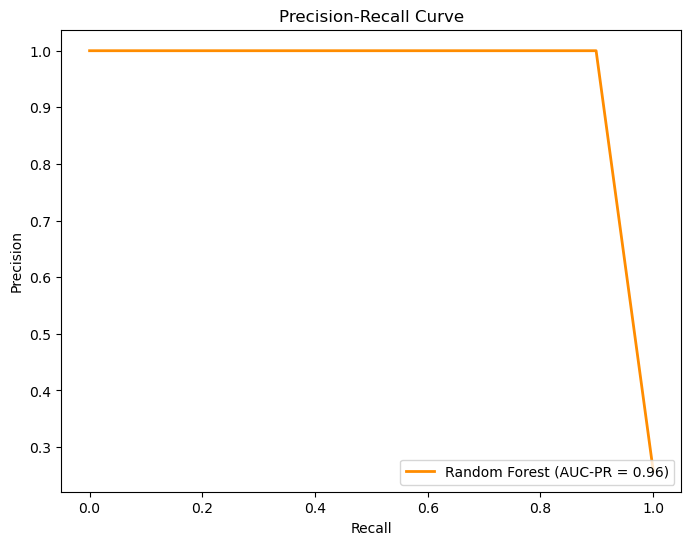

In [48]:
y_pred = random_forest.predict(X_test)
plot_aucpr_curve(y_test, y_pred, "Random Forest")